In [55]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
words= open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [57]:
len(words)

32033

In [58]:
chars =sorted(list(set(''.join(words))))
stoi= {s:i+1 for i,s in enumerate(chars)}
print(chars)
print(stoi)
stoi['.']=0
print(stoi)
itos= {s:i for i,s in stoi.items()}
print(itos)
vocab_size=len(itos)
print(vocab_size)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [59]:
block_size = 3
def build_dataset(words):
    X , Y = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        #print(context)
        for ch in w + '.':
            #print(ch)
            ix= stoi[ch]
            #print(ix)
            X.append(context)
            Y.append(ix)
            context= context[1:] + [ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    #print("X is",X,Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8 * len(words))
n2=int(0.9 * len(words))

Xtr,Ytr= build_dataset(words[:n1])
Xdev,Ydev= build_dataset(words[n1:n2])
Xte, Yte= build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
n_embd =10
n_hidden = 200

g=torch.Generator().manual_seed(214783647)
C= torch.randn((vocab_size, n_embd) ,          generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
W2=torch.randn((n_hidden, vocab_size),         generator=g) *0.01
b1=torch.randn(n_hidden,                       generator=g)*0.01
b2=torch.randn(vocab_size ,                    generator=g)*0


bngain= torch.ones((1, n_hidden))
bnbias= torch.zeros((1, n_hidden))
bnmean_running= torch.zeros(1,n_hidden)
bnstd_running= torch.ones(1, n_hidden)

parameters=[ C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True
    

11897


In [61]:
(torch.randn(10000) * 0.2).std()

tensor(0.2002)

torch.Size([1000, 200])
tensor(-0.0029) tensor(1.0036)
tensor(0.0026) tensor(1.0032)


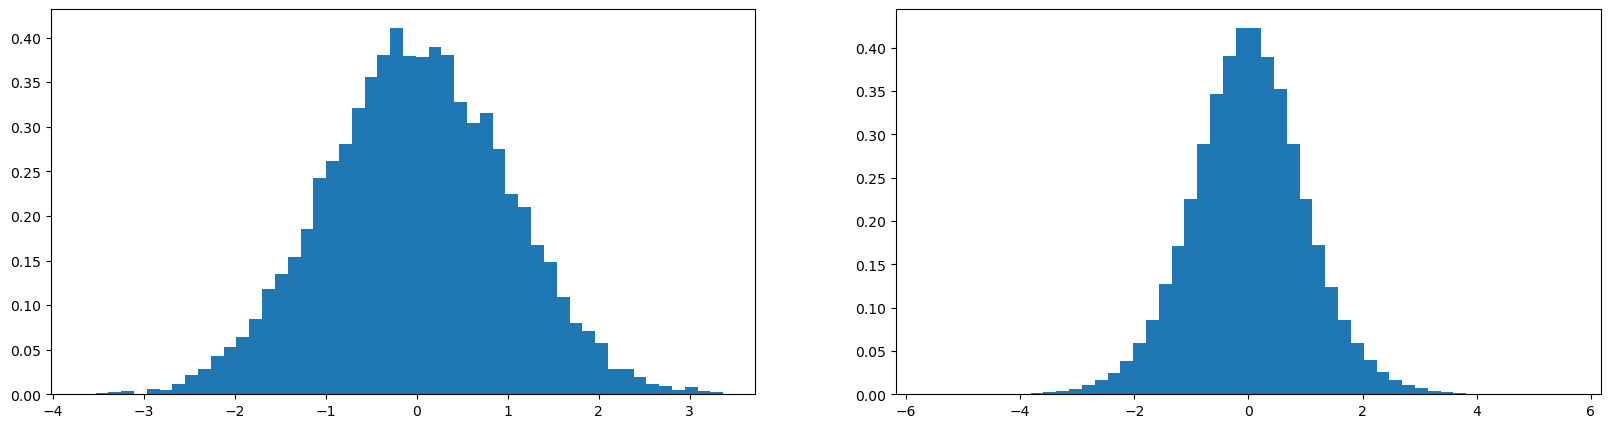

In [62]:
x=torch.randn(1000, 10)
w=torch.randn(10, 200) / 10**0.5
y= x @ w
print(y.shape)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


In [63]:
hpreact.shape

torch.Size([32, 200])

In [64]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [65]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [66]:
max_steps= 200000
batch_size= 32
lossi=[]

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator=g)
    Xb,Yb= Xtr[ix],Ytr[ix]

    #forward pass
    emb= C[Xb]
    embcat= emb.view(emb.shape[0],-1)
    hpreact= embcat @ W1 + b1

    #Batch Norm
    bnmeani= hpreact.mean(0, keepdim=True)
    bnstdi= hpreact.std(0, keepdim=True)
    hpreact= bngain * (hpreact - bnmeani) / bnstdi +bnbias

    with torch.no_grad():
        bnmean_running= 0.999 * bnmean_running + 0.001 *bnmeani
        bnstd_running= 0.999 * bnstd_running + 0.001 * bnstdi
    
    
    
    h=torch.tanh(hpreact)
    logits= h@ W2+b2
    loss= F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad= None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad

    if i% 100000 ==0:
        print(f'{ i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break
    

      0/ 200000 : 3.2876
 100000/ 200000 : 1.8224


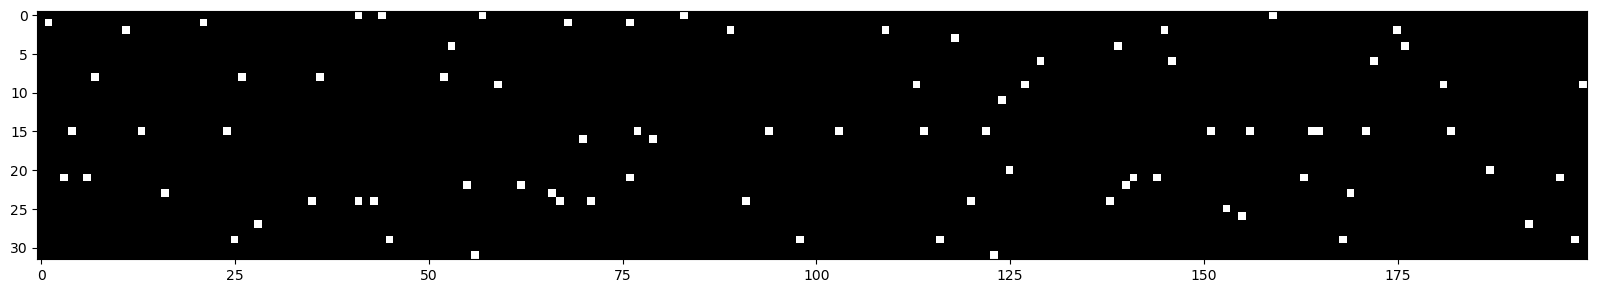

In [67]:
plt.figure(figsize=(20,10))
plt. imshow(h.abs ()> 0.99, cmap='gray', interpolation='nearest')

In [68]:
torch.tensor(1/27.0).log()

tensor(-3.2958)

In [69]:
#logits=torch.tensor([-3.0, 5.0, 0.0, 2.0])
logits= torch.randn(4) * 100
probs= torch.softmax(logits, dim=0)
loss= -probs[2].log()
probs, loss

(tensor([1.0000e+00, 6.6129e-36, 0.0000e+00, 0.0000e+00]), tensor(inf))

(array([184., 184., 139., 157., 116., 111., 125., 126., 128., 100., 127.,
        142.,  97.,  94.,  98., 100., 113., 108., 110., 113., 134., 109.,
        167., 149., 194., 157., 193., 173., 126., 130.,  79., 148., 109.,
        105.,  92., 114.,  84., 100.,  98.,  75.,  95., 112., 102., 133.,
        123., 138., 157., 164., 167., 201.]),
 array([-9.99523759e-01, -9.59549017e-01, -9.19574275e-01, -8.79599533e-01,
        -8.39624791e-01, -7.99650049e-01, -7.59675307e-01, -7.19700565e-01,
        -6.79725823e-01, -6.39751081e-01, -5.99776340e-01, -5.59801598e-01,
        -5.19826856e-01, -4.79852114e-01, -4.39877372e-01, -3.99902630e-01,
        -3.59927888e-01, -3.19953146e-01, -2.79978404e-01, -2.40003662e-01,
        -2.00028920e-01, -1.60054178e-01, -1.20079436e-01, -8.01046944e-02,
        -4.01299524e-02, -1.55210495e-04,  3.98195314e-02,  7.97942734e-02,
         1.19769015e-01,  1.59743757e-01,  1.99718499e-01,  2.39693241e-01,
         2.79667983e-01,  3.19642725e-01,  3.59617

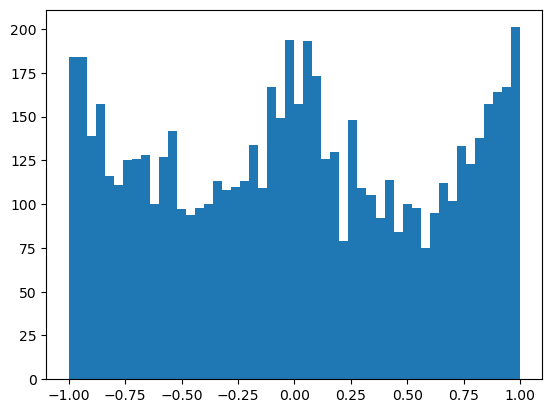

In [70]:
plt.hist(h.view(-1).tolist(), 50)

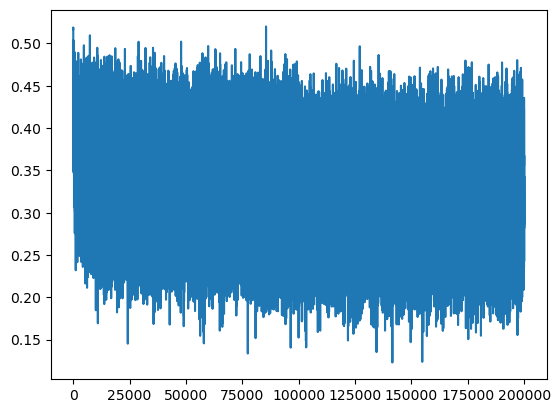

In [71]:
plt.plot(lossi)

In [72]:
with torch.no_grad():
    emb = C[Xtr]  #(32,3,2)
    embcat=emb.view(emb.shape[0], -1)
    hpreact= embcat @ W1 + b1
    bnmean= hpreact.mean(0, keepdim=True)
    bnstd=hpreact.std(0, keepdim=True) 

In [73]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte),
    }[split]
    emb = C[x]  #(32,3,2)
    embcat=emb.view(emb.shape[0], -1)
    hpreact= embcat @ W1 + b1
    hpreact= bngain * (hpreact - bnmean_running) / bnstd_running +bnbias
    h=torch.tanh(hpreact)
    logits = h @W2+b2
    loss=F.cross_entropy(logits,y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0770483016967773
val 2.115203857421875


In [74]:
g =torch.Generator().manual_seed(2147483647 +10)
for _ in range(20):
    out= []
    context= [0]* block_size
    while True:
        emb= C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1) @ W1 +b1)
        logits= h @ W2 +b2
        probs= F.softmax(logits, dim=1)
        ix= torch.multinomial(probs, num_samples=1, generator= g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
             break
    print("".join(itos[i] for i in out))

narmahrablyn.
kahlynne.
revty.
hathmeke.
rahnikabhdiyah.
kaquin.
rummishcerihvon.
najamvi.
mackindleinna.
rockevlynn.
quinte.
rudifryn.
kakhellins.
bley.
zalin.
kaleynantrevalan.
busticsya.
naq.
zabz.
zyllin.


In [6]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight= torch.randn((fan_in, fan_out), generator=g) / fan_in **0.5
        self.bias= torch.zeros(fan_out) if bias else None

    def __call__ (self,x):
        self.out = x @self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps= eps
        self.momentum= momentum
        self.training= True
        self.gamma= torch.ones(dim)
        self.beta= torch.zeros(dim)

        self.running_mean=torch.zeros(dim)
        self.running_var= torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar= x.var(0, keepdim= True, unbiased= True)
        else:
            xmean= self.running_mean
            xvar= self.running_var
        xhat= (x-xmean) / torch.sqrt(xvar +self.eps)
        self.out= self.gamma *xhat +self.bias

        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean * xmean
                self.running_var= (1- self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd= 10
n_hidden= 100
g= torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size, n_embd), generator=g)
